In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

plt.style.use('seaborn-whitegrid')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


**8H1** Run the model below and then inspect the posterior distribution and explain what it is accomplishing.

```
mp <- map2stan(
    alist(
        a ~ dnorm(0,1),
        b ~ dcauchy(0,1)
    ),
    data=list(y=1),
    start=list(a=0,b=0),
    iter=1e4, warmup=100 , WAIC=FALSE )
```

Compare the samples for the parameters `a` and `b`. Can you explain the different trace plots, using what you know about the Cauchy distribution?



In [2]:
with pm.Model() as model_8h1:
    a = pm.Normal('a', mu=0, sd=1)
    b = pm.Cauchy('b', alpha=0, beta=1)

    model_8h1.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:13<00:00, 913.75draws/s]
The acceptance probability does not match the target. It is 0.9628618230061867, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


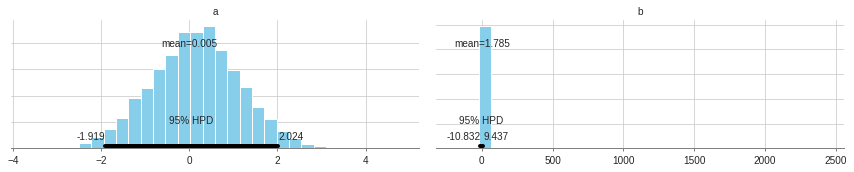

In [3]:
pm.plot_posterior(model_8h1.trace)
None

**8H2** Recall the divorce rate example from Chapter 5. Repeat that analysis, using map2stan this time, fitting models `m5.1`, `m5.2`, and `m5.3`. Use compare to compare the models on the basis of WAIC. Explain the results.


In [4]:
waffle = pd.read_csv('data/WaffleDivorce.csv', sep=';')

In [5]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=10, sd=10)
    ba = pm.Normal('ba', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic(
        'mu',
        a + ba * (waffle['MedianAgeMarriage'] - waffle['MedianAgeMarriage'].mean()) 
                 / waffle['MedianAgeMarriage'].std()
    )
    
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=waffle['Divorce'])

    model_5_1.name = 'm5.1'
    model_5_1.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ba, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1899.96draws/s]


In [6]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=10, sd=10)
    br = pm.Normal('br', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic(
        'mu',
        a + br * (waffle['Marriage'] - waffle['Marriage'].mean())
                 / waffle['Marriage'].std()
    )
    
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=waffle['Divorce'])

    model_5_2.name = 'm5.2'
    model_5_2.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:06<00:00, 1760.30draws/s]


In [7]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=10, sd=10)
    ba = pm.Normal('ba', mu=0, sd=1)
    br = pm.Normal('br', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic(
        'mu',
        a
        + ba * (waffle['MedianAgeMarriage'] - waffle['MedianAgeMarriage'].mean()) 
                 / waffle['MedianAgeMarriage'].std()
        + br * (waffle['Marriage'] - waffle['Marriage'].mean())
                 / waffle['Marriage'].std()
    )
    
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=waffle['Divorce'])

    model_5_3.name = 'm5.3'
    model_5_3.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, ba, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1307.21draws/s]


In [8]:
pm.compare({
        model_5_1: model_5_1.trace,
        model_5_2: model_5_2.trace,
        model_5_3: model_5_3.trace,
    },
    method='BB-pseudo-BMA'
)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
m5.1,186.27,3.86,0,0.66,12.18,0,1
m5.3,188.11,4.93,1.85,0.27,12.17,0.8,1
m5.2,199.86,3.18,13.6,0.07,10.02,9.03,1


---
**8H3** 8H3. Sometimes changing a prior for one parameter has unanticipated effects on other parameters. This is because when a parameter is highly correlated with another parameter in the posterior, the prior influences both parameters. Here’s an example to work and think through. Go back to the leg length example in Chapter 5. Here is the code again, which simulates height and leg lengths for 100 imagined individuals

In [9]:
N = 100

height = stats.norm(loc=10, scale=2).rvs(N)
leg_prop = stats.uniform(0.4, 0.5).rvs(N)
leg_left = leg_prop * height + stats.norm(loc=0, scale=0.02).rvs(N)
leg_right = leg_prop * height + stats.norm(loc=0, scale=0.02).rvs(N)

data = pd.DataFrame(dict(
    height=height, leg_prop=leg_prop, leg_left=leg_left, leg_right=leg_right
))

data.head()

,height,leg_prop,leg_left,leg_right
0,9.506519,0.777847,7.386613,7.401012
1,7.924869,0.689147,5.449468,5.464275
2,11.490931,0.500530,5.760454,5.777771
3,6.764755,0.645378,4.355596,4.374617
4,6.176718,0.720725,4.438574,4.461163


And below is the model you fit before, resulting in a highly correlated posterior for the two beta
parameters. This time, fit the model using map2stan:


In [10]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)

    mu = pm.Deterministic('mu', a + bl * data.leg_left.values + br * data.leg_right.values)

    sigma = pm.HalfCauchy('sigma', beta=10)
    height = pm.Normal('height', mu=mu, sd=sigma,
                       observed=data.height.values)

    m5_8.name = 'm5_8'
    start = pm.find_MAP()
    m5_8.trace = pm.sample(3000, tune=500, chains=2, start=start)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -182.01, ||grad|| = 0.17759: 100%|██████████| 56/56 [00:00<00:00, 1199.36it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|██████████| 7000/7000 [05:32<00:00,  9.84draws/s]
The acceptance probability does not match the target. It is 0.880517526306921, but should be close to 0.8. Try to increase the number of tuning steps.


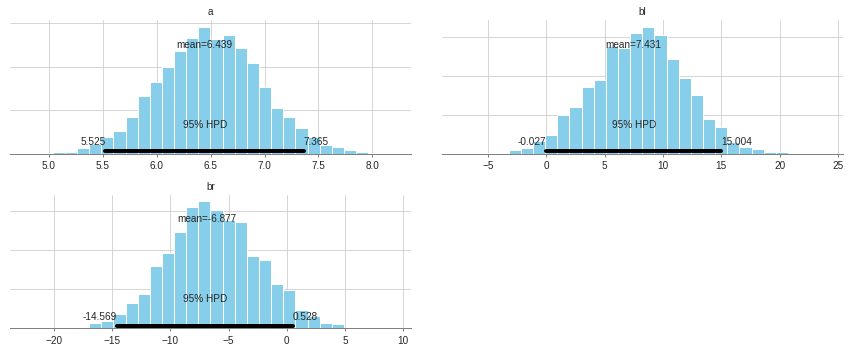

In [11]:
pm.plot_posterior(m5_8.trace, varnames=['a', 'bl', 'br'])
None

Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for br so that it is strictly positive:


In [12]:
with pm.Model() as m5_8_s2:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Bound(pm.Normal, lower=0)('br', mu=2, sd=10)

    mu = pm.Deterministic('mu', a + bl * data.leg_left.values + br * data.leg_right.values)

    sigma = pm.HalfCauchy('sigma', beta=10)
    height = pm.Normal('height', mu=mu, sd=sigma,
                       observed=data.height.values)

    m5_8_s2.name = 'm5_8_s2'
    start = pm.find_MAP()
    m5_8_s2.trace = pm.sample(3000, tune=500, chains=2, start=start)

/home/petrushev/projects/jup_venv/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -183.63, ||grad|| = 0.045203: 100%|██████████| 97/97 [00:00<00:00, 1866.50it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|██████████| 7000/7000 [01:08<00:00, 101.62draws/s]
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
There were 238 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6571558072648461, but should be close to 0.8.

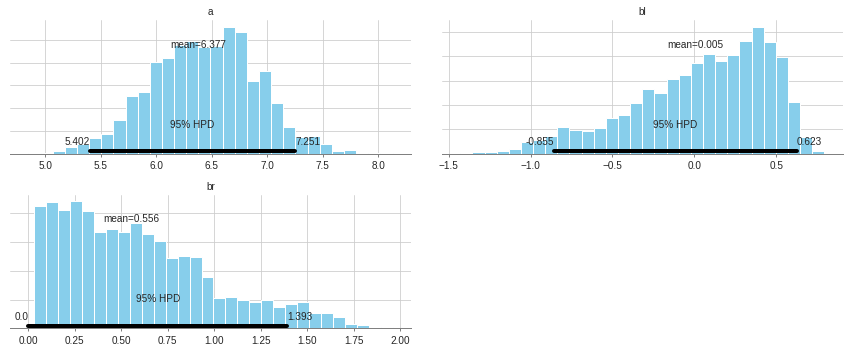

In [13]:
pm.plot_posterior(m5_8_s2.trace, varnames=['a', 'bl', 'br'])
None